In [1]:
%matplotlib inline
import pandas as pd
import matplotlib as mpl
from matplotlib import pylab as plt
import matplotlib.dates as mdates
import seaborn as sns

import collections

import numpy as np
import tensorflow.compat.v2 as tf
import tensorflow_probability as tfp

from tensorflow_probability import distributions as tfd
from tensorflow_probability import sts

tf.enable_v2_behavior()

/Users/SeanNassimiha/miniforge3/envs/tfprob/lib/python3.8/site-packages/jax/_src/lib/__init__.py:33: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


In [2]:
# if tf.test.gpu_device_name() != '/device:GPU:0':
#     print('WARNING: GPU device not found.')
# else:
#     print('SUCCESS: Found GPU: {}'.format(tf.test.gpu_device_name()))


In [3]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

sns.set_context("notebook", font_scale=1.)
sns.set_style("whitegrid")
%config InlineBackend.figure_format = 'retina'

In [4]:
def plot_forecast(x, y,
                  forecast_mean, forecast_scale, forecast_samples,
                  title, x_locator=None, x_formatter=None):
    """Plot a forecast distribution against the 'true' time series."""
    colors = sns.color_palette()
    c1, c2 = colors[0], colors[1]
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(1, 1, 1)

    num_steps = len(y)
    num_steps_forecast = forecast_mean.shape[-1]
    num_steps_train = num_steps - num_steps_forecast


    ax.plot(x, y, lw=2, color=c1, label='ground truth')

    forecast_steps = np.arange(
      x[num_steps_train],
      x[num_steps_train]+num_steps_forecast,
      dtype=x.dtype)

    ax.plot(forecast_steps, forecast_samples.T, lw=1, color=c2, alpha=0.1)

    ax.plot(forecast_steps, forecast_mean, lw=2, ls='--', color=c2,
           label='forecast')
    ax.fill_between(forecast_steps,
                   forecast_mean-2*forecast_scale,
                   forecast_mean+2*forecast_scale, color=c2, alpha=0.2)

    ymin, ymax = min(np.min(forecast_samples), np.min(y)), max(np.max(forecast_samples), np.max(y))
    yrange = ymax-ymin
    ax.set_ylim([ymin - yrange*0.1, ymax + yrange*0.1])
    ax.set_title("{}".format(title))
    ax.legend()

    if x_locator is not None:
        ax.xaxis.set_major_locator(x_locator)
        ax.xaxis.set_major_formatter(x_formatter)
        fig.autofmt_xdate()

    return fig, ax

In [5]:
def plot_components(dates,
                    component_means_dict,
                    component_stddevs_dict,
                    x_locator=None,
                    x_formatter=None):
    """Plot the contributions of posterior components in a single figure."""
    colors = sns.color_palette()
    c1, c2 = colors[0], colors[1]

    axes_dict = collections.OrderedDict()
    num_components = len(component_means_dict)
    fig = plt.figure(figsize=(12, 2.5 * num_components))
    for i, component_name in enumerate(component_means_dict.keys()):
        component_mean = component_means_dict[component_name]
        component_stddev = component_stddevs_dict[component_name]

        ax = fig.add_subplot(num_components,1,1+i)
        ax.plot(dates, component_mean, lw=2)
        ax.fill_between(dates,
                         component_mean-2*component_stddev,
                         component_mean+2*component_stddev,
                         color=c2, alpha=0.5)
        ax.set_title(component_name)
        if x_locator is not None:
            ax.xaxis.set_major_locator(x_locator)
            ax.xaxis.set_major_formatter(x_formatter)
        axes_dict[component_name] = ax
    fig.autofmt_xdate()
    fig.tight_layout()
    return fig, axes_dict

In [6]:
def plot_one_step_predictive(dates, observed_time_series,
                             one_step_mean, one_step_scale,
                             x_locator=None, x_formatter=None):
    """Plot a time series against a model's one-step predictions."""

    colors = sns.color_palette()
    c1, c2 = colors[0], colors[1]

    fig=plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(1,1,1)
    num_timesteps = one_step_mean.shape[-1]
    ax.plot(dates, observed_time_series, label="observed time series", color=c1)
    ax.plot(dates, one_step_mean, label="one-step prediction", color=c2)
    ax.fill_between(dates,
                  one_step_mean - one_step_scale,
                  one_step_mean + one_step_scale,
                  alpha=0.1, color=c2)
    ax.legend()

    if x_locator is not None:
        ax.xaxis.set_major_locator(x_locator)
        ax.xaxis.set_major_formatter(x_formatter)
        fig.autofmt_xdate()
    fig.tight_layout()
    return fig, ax

In [7]:
data =  pd.read_csv('../../../Data/pv_power_df_5day_capacity_scaled.csv', index_col='datetime').drop(columns=['2657', '2828']) #DROPPING FAULTY SYSTEMS
uk_pv = pd.read_csv('../../../Data/system_metadata_location_rounded.csv')
uk_pv['ss_id_string'] = uk_pv['ss_id'].astype('str')

In [8]:
ts = data.iloc[:10000, 0].values

In [9]:
num_forecast_steps = 24 # Forecast the final ten years, given previous data
ts_train = ts[:-num_forecast_steps]

dates = data.iloc[:10000, 0].index.values
# co2_loc = mdates.YearLocator(3)
# co2_fmt = mdates.DateFormatter('%Y')

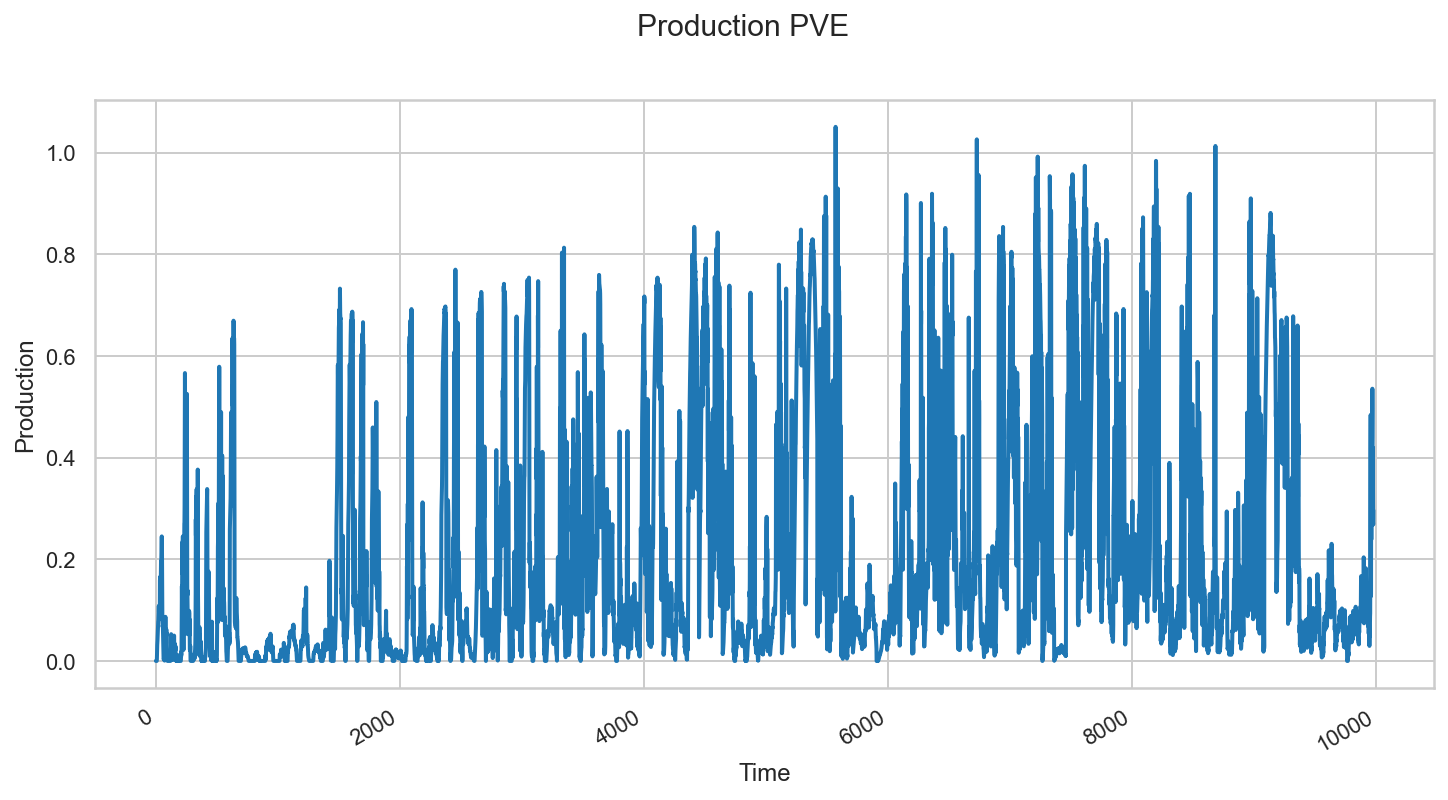

In [10]:
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot( ts_train, lw=2, label="training data")
# ax.xaxis.set_major_locator(co2_loc)
# ax.xaxis.set_major_formatter(co2_fmt)
ax.set_ylabel("Production")
ax.set_xlabel("Time")
fig.suptitle("Production PVE",
             fontsize=15)

fig.autofmt_xdate()

In [11]:
def build_model(observed_time_series):
    
    trend = sts.LocalLinearTrend(observed_time_series=observed_time_series)
    seasonal_daily = tfp.sts.Seasonal(num_seasons=97, observed_time_series=observed_time_series, name = 'daily pattern')
    season_yearly = tfp.sts.Seasonal(num_seasons=365, num_steps_per_season=97, observed_time_series=observed_time_series, name = 'yearly pattern')
    model = sts.Sum([trend, seasonal_daily,season_yearly ], observed_time_series=observed_time_series)
    return model

In [12]:
with tf.device("/cpu:0"):
    model = build_model(ts_train)

    # Build the variational surrogate posteriors `qs`.
    variational_posteriors = tfp.sts.build_factored_surrogate_posterior(model=model)

Metal device set to: Apple M1
Instructions for updating:
Do not call `graph_parents`.
Instructions for updating:
`MultivariateNormalFullCovariance` is deprecated, use `MultivariateNormalTriL(loc=loc, scale_tril=tf.linalg.cholesky(covariance_matrix))` instead.


In [ ]:
with tf.device("/cpu:0"):
    #@title Minimize the variational loss.

    # Allow external control of optimization to reduce test runtimes.
    num_variational_steps = 5 # @param { isTemplate: true}
    num_variational_steps = int(num_variational_steps)

    # Build and optimize the variational loss function.
    elbo_loss_curve = tfp.vi.fit_surrogate_posterior(
        target_log_prob_fn=model.joint_distribution(
            observed_time_series=ts_train).log_prob,
        surrogate_posterior=variational_posteriors,
        optimizer=tf.optimizers.Adam(learning_rate=0.1),
        num_steps=num_variational_steps,
        jit_compile=False)

    plt.plot(elbo_loss_curve)
    plt.show()

    # Draw samples from the variational posterior.
    q_samples = variational_posteriors.sample(50)

Instructions for updating:
`scale_identity_multiplier` is deprecated; please combine it into `scale_diag` directly instead.


2022-06-21 13:09:34.155506: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


In [ ]:
print("Inferred parameters:")
for param in model.parameters:
    print("{}: {} +- {}".format(param.name,
                              np.mean(q_samples[param.name], axis=0),
                              np.std(q_samples[param.name], axis=0)))